In [37]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

### Data Exploration and Understanding

In [38]:
# Loading in the dataset
df = pd.read_csv("brca_data_w_subtypes.csv")
print(df.info())
print()
print(df.head())
print()
print(df.describe())
print()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Columns: 1941 entries, rs_CLEC3A to histological.type
dtypes: float64(827), int64(1110), object(4)
memory usage: 10.4+ MB
None

   rs_CLEC3A    rs_CPB1  rs_SCGB2A2  rs_SCGB1D2    rs_TFF1   rs_MUCL1  \
0   0.892818   6.580103   14.123672   10.606501  13.189237   6.649466   
1   0.000000   3.691311   17.116090   15.517231   9.867616   9.691667   
2   3.748150   4.375255    9.658123    5.326983  12.109539  11.644307   
3   0.000000  18.235519   18.535480   14.533584  14.078992   8.913760   
4   0.000000   4.583724   15.711865   12.804521   8.881669   8.430028   

    rs_GSTM1     rs_PIP  rs_ADIPOQ   rs_ADH1B  ...  pp_p62.LCK.ligand  \
0  10.520335  10.338490  10.248379  10.229970  ...          -0.691766   
1   8.179522   7.911723   1.289598   1.818891  ...           0.279067   
2  10.517330   5.114925  11.975349  11.911437  ...           0.219910   
3  10.557465  13.304434   8.205059   9.211476  ...          -0.266554

### Getting specifics about the Multi-omics dataset and other correlations

In [39]:
print("Multi-omics variables in the dataset.")
print("Number of RNAseq expression variables:", len([match for match in df.columns if match.startswith("rs")]))
print("Number of Copy Number Variables:", len([match for match in df.columns if match.startswith("cn")]))
print("Number of Protein Levels Variables:", len([match for match in df.columns if match.startswith("pp")]))
print("Number of Somatic Mutations in data:", len([match for match in df.columns if match.startswith("mu")]))

print()
print("There are 5 outcomes for the omics data above")
print("Vital Status:", df["vital.status"].unique())
print("Progesterone Receptors: ", (df["PR.Status"]).unique())
print("Estrogen Receptors: ", (df["ER.Status"]).unique())
print("HER2 Status", (df["HER2.Final.Status"]).unique())
print("Histological Cancer Subtype", (df["histological.type"]).unique())

Multi-omics variables in the dataset.
Number of RNAseq expression variables: 604
Number of Copy Number Variables: 860
Number of Protein Levels Variables: 223
Number of Somatic Mutations in data: 249

There are 5 outcomes for the omics data above
Vital Status: [0 1]
Progesterone Receptors:  ['Positive' 'Negative' nan 'Performed but Not Available' 'Indeterminate'
 'Not Performed']
Estrogen Receptors:  ['Positive' 'Negative' nan 'Performed but Not Available' 'Indeterminate'
 'Not Performed']
HER2 Status ['Negative' nan 'Positive' 'Equivocal' 'Not Available']
Histological Cancer Subtype ['infiltrating ductal carcinoma' 'infiltrating lobular carcinoma']


In [40]:
gene_suffix = ['rs_', 'cn_', 'mu_']
genes_all = []

for col in df.columns:
    for suffix in gene_suffix:
        if col.startswith(suffix):
            gene = col[len(suffix):]
            if all(suffix + gene in df.columns for suffix in gene_suffix):
                genes_all.append(gene)
unique_genes = set(genes_all)
print(unique_genes)

{'CNTNAP2', 'MUC16', 'FOXA1', 'FAT2', 'PEG3', 'MYH11', 'GPR98'}


### Analyzing data of a single gene and multiple genes multi-omics data to understand and predict effects on the outcomes

In [41]:
# Selecting genes here to analyze and use the first one for single gene omics analysis
df_muc16 = df[[val for val in df.columns if "MUC16" in val]]
print(df_muc16)


     rs_MUC16  cn_MUC16  mu_MUC16
0    2.715718         1         1
1    4.811800         0         0
2    6.842515        -1         0
3    4.535344        -1         0
4    4.676053         0         1
..        ...       ...       ...
700  2.054710         0         0
701  3.834195         0         0
702  3.323918         0         0
703  1.316783         0         0
704  7.617837         0         1

[705 rows x 3 columns]


In [42]:
omics_unique_genes = [col for col in df.columns if any(gene in col for gene in unique_genes)]
print(omics_unique_genes)

['rs_MUC16', 'rs_CNTNAP2', 'rs_GPR98', 'rs_FOXA1', 'rs_FAT2', 'rs_PEG3', 'rs_MYH11', 'cn_GPR98', 'cn_FAT2', 'cn_CNTNAP2', 'cn_FOXA1', 'cn_MYH11', 'cn_MUC16', 'cn_PEG3', 'mu_MUC16', 'mu_FAT2', 'mu_GPR98', 'mu_MYH11', 'mu_FOXA1', 'mu_CNTNAP2', 'mu_PEG3', 'pp_MYH11']


In [43]:
for gene_data in omics_unique_genes:
    print(f"T-Test on relationship between {gene_data} and patient survival")
    mean_alive = df.loc[df["vital.status"] == 0, gene_data].mean()
    mean_dead = df.loc[df["vital.status"] == 1, gene_data].mean()
    # print(f"Mean in Dead: {mean_dead}")
    # print(f"Mean in Alive: {mean_alive}")
    
    t_stat, p_val = ttest_ind(df.loc[df["vital.status"] == 0, gene_data],
                              df.loc[df["vital.status"] == 1, gene_data])
    
    print(f'T-statistic: {t_stat}')
    print(f'P-value: {p_val}')
    print(f"")

T-Test on relationship between rs_MUC16 and patient survival
T-statistic: -2.1354729424193644
P-value: 0.03306737441965191

T-Test on relationship between rs_CNTNAP2 and patient survival
T-statistic: 2.699933744804915
P-value: 0.0071021329740718715

T-Test on relationship between rs_GPR98 and patient survival
T-statistic: -1.7579877371890567
P-value: 0.07918474779417059

T-Test on relationship between rs_FOXA1 and patient survival
T-statistic: 0.8244993291490502
P-value: 0.4099355518391745

T-Test on relationship between rs_FAT2 and patient survival
T-statistic: -3.2309560776720154
P-value: 0.0012912649579201027

T-Test on relationship between rs_PEG3 and patient survival
T-statistic: -2.706877930325158
P-value: 0.006956801568734718

T-Test on relationship between rs_MYH11 and patient survival
T-statistic: -3.8327667389375693
P-value: 0.00013806225200052157

T-Test on relationship between cn_GPR98 and patient survival
T-statistic: 0.524308819159188
P-value: 0.6002290347586479

T-Test o

In [44]:
df_unique_genes = df[omics_unique_genes]
# df_unique_genes = df_unique_genes.drop('pp_MYH11', axis = 1)
print(df_unique_genes)


     rs_MUC16  rs_CNTNAP2  rs_GPR98   rs_FOXA1   rs_FAT2    rs_PEG3  \
0    2.715718    9.885785  8.891220  12.696589  8.396041   8.197286   
1    4.811800    9.344277  7.883318  12.464073  9.128518   8.314152   
2    6.842515    8.652057  7.603679  12.638795  7.117963  12.233405   
3    4.535344   12.586292  8.171135  13.753339  5.684499   5.409554   
4    4.676053   10.732571  8.796819  13.444034  6.455607  11.649508   
..        ...         ...       ...        ...       ...        ...   
700  2.054710    0.926986  7.342820  12.633520  5.950426  10.771239   
701  3.834195    4.867086  8.013366  12.108079  5.290233   6.583645   
702  3.323918    5.484831  7.116687  12.696575  5.972904   6.639109   
703  1.316783    7.546005  5.313514  12.980322  4.121148   6.967745   
704  7.617837    3.169075  9.137739  12.965885  6.938951   5.119161   

      rs_MYH11  cn_GPR98  cn_FAT2  cn_CNTNAP2  ...  cn_MUC16  cn_PEG3  \
0    11.838799         0        0           1  ...         1        1   
1

In [45]:
random.seed(42)
# Try the Logistic Regression Model
X = df_unique_genes
y = df['vital.status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

predictions_survival = log_reg.predict(X_test)
print(classification_report(y_test, predictions_survival))


              precision    recall  f1-score   support

           0       0.89      0.99      0.94       125
           1       0.50      0.06      0.11        16

    accuracy                           0.89       141
   macro avg       0.70      0.53      0.53       141
weighted avg       0.85      0.89      0.85       141



c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
random.seed(42)
# Try the Gradient Boost Model
gradient_boost = GradientBoostingClassifier()
gradient_boost.fit(X_train, y_train)

predictions_survival = gradient_boost.predict(X_test)
print(classification_report(y_test, predictions_survival))


              precision    recall  f1-score   support

           0       0.89      0.98      0.93       125
           1       0.25      0.06      0.10        16

    accuracy                           0.87       141
   macro avg       0.57      0.52      0.52       141
weighted avg       0.82      0.87      0.84       141



In [47]:
random.seed(42)
# Try the Neural Network Model on the omics_data
neural_network = MLPClassifier()
neural_network.fit(X_train, y_train)

predictions_survival = neural_network.predict(X_test)
print(classification_report(y_test, predictions_survival))

              precision    recall  f1-score   support

           0       0.89      0.98      0.94       125
           1       0.33      0.06      0.11        16

    accuracy                           0.88       141
   macro avg       0.61      0.52      0.52       141
weighted avg       0.83      0.88      0.84       141



c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [48]:
random.seed(42)
# Try the Naives Bayes Model on the omics_data
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

predictions_survival = naive_bayes.predict(X_test)
print(classification_report(y_test, predictions_survival))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       125
           1       0.22      0.25      0.24        16

    accuracy                           0.82       141
   macro avg       0.56      0.57      0.57       141
weighted avg       0.83      0.82      0.82       141



In [49]:
random.seed(42)
# Try the Random Forest Model on the omics_data
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

predictions_survival = clf.predict(X_test)
print(classification_report(y_test, predictions_survival))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       125
           1       0.25      0.06      0.10        16

    accuracy                           0.87       141
   macro avg       0.57      0.52      0.52       141
weighted avg       0.82      0.87      0.84       141



In [59]:
random.seed(42)
# Try the Decision Tree Model on the omics_data
clf2 = DecisionTreeClassifier()
clf2.fit(X_train, y_train)

predictions_survival = clf2.predict(X_test)
print(classification_report(y_test, predictions_survival))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       125
           1       0.12      0.12      0.12        16

    accuracy                           0.79       141
   macro avg       0.50      0.50      0.50       141
weighted avg       0.80      0.79      0.80       141



In [51]:
random.seed(42)
# Try the SVM model on the omics_data
vector = svm.SVC()
vector.fit(X_train, y_train)

predictions_survival = vector.predict(X_test)
print(classification_report(y_test, predictions_survival))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       125
           1       0.00      0.00      0.00        16

    accuracy                           0.89       141
   macro avg       0.44      0.50      0.47       141
weighted avg       0.79      0.89      0.83       141



c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

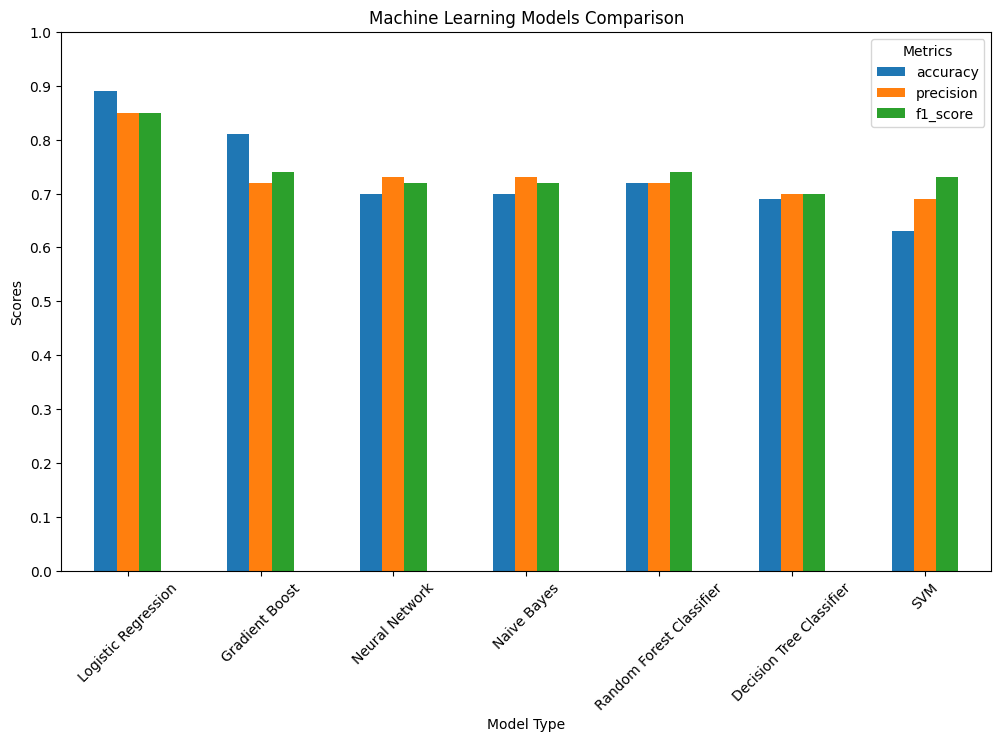

In [68]:
model_metrics = {
    'Logistic Regression': {'accuracy': 0.89, 'precision': 0.85, 'f1_score': 0.85},
    'Gradient Boost': {'accuracy': 0.81, 'precision': 0.72, 'f1_score': 0.74},
    'Neural Network': {'accuracy': 0.70, 'precision': 0.73, 'f1_score': 0.72},
    'Naive Bayes': {'accuracy': 0.70, 'precision': 0.73, 'f1_score': 0.72},
    'Random Forest Classifier': {'accuracy': 0.72, 'precision': 0.72, 'f1_score': 0.74},
    'Decision Tree Classifier': {'accuracy': 0.69, 'precision': 0.70, 'f1_score': 0.70},
    'SVM': {'accuracy': 0.63, 'precision': 0.69, 'f1_score': 0.73}
}

df = pd.DataFrame(model_metrics).T

# Plotting
df.plot(kind='bar', figsize=(12, 7))
plt.title('Machine Learning Models Comparison')
plt.ylabel('Scores')
plt.ylim(0,1)
plt.yticks([i * 0.1 for i in range(11)])
plt.xlabel('Model Type')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.show()

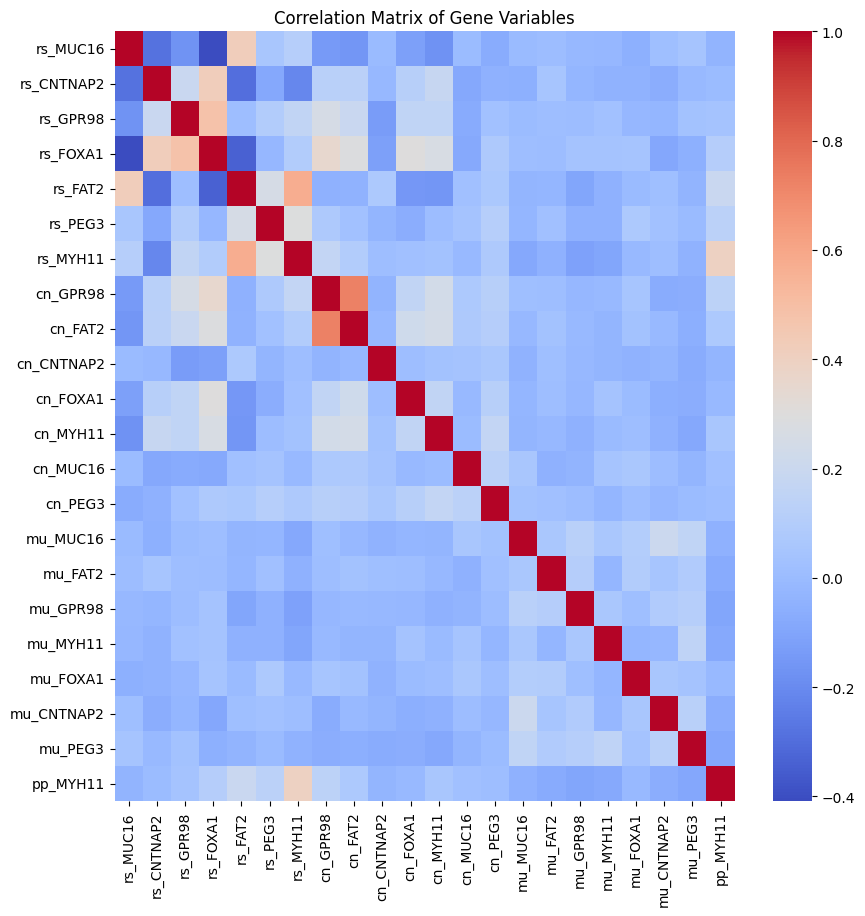

In [52]:
corr_matrix = df_unique_genes.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix of Gene Variables")
plt.show()